# Exploring Classification Performance

Let's load in any libraries we will use in this notebook. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns

#import torch which has many of the functions to build deep learning models and to train them
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Subset

#import torchvision, which was lots of functions for loading and working with image data
import torchvision
import torchvision.transforms as transforms


#this is a nice progress bar representation that will be good to measure progress during training
import tqdm

#for creating confusion matrices from predictions
from sklearn.metrics import ConfusionMatrixDisplay

# 1) Splitting into a training and validation dataset

As we did in Week 5, we're going to use the dataset with 20 dog species. 
However, I'm using the 'train' folder as train and validation dataset, while the 'val' folder will be our test dataset where we will compute evaluation metrics.

In [3]:
imagenet_means = (0.485, 0.456, 0.406)
imagenet_stds = (0.229, 0.224, 0.225)

transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Resize((224, 224)), 
     transforms.Normalize(imagenet_means, imagenet_stds)])

trainval_dataset = torchvision.datasets.ImageFolder('../Week 5/stanford_dogs_subset/train', transform=transform)

Let's look the number of samples per class in the ''stanford_dogs_subset/train''

<Figure size 1000x500 with 0 Axes>

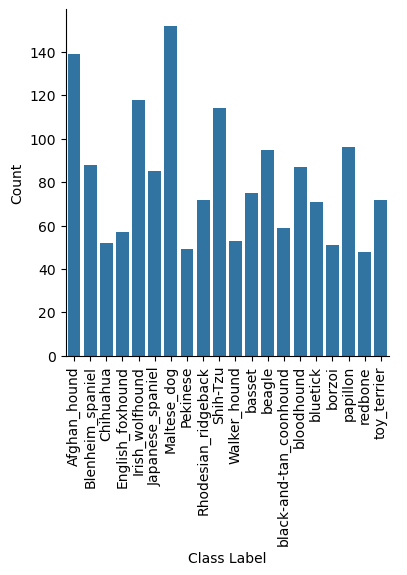

In [4]:
num_classes = len(trainval_dataset.classes)
plt.figure(figsize=(10,5))
g = sns.catplot(x=trainval_dataset.targets, kind="count", height=4, aspect=1)
g.set_axis_labels("Class Label", "Count")
for ax in g.axes.flatten():
    ax.set_xticks(range(num_classes))
    ax.set_xticklabels(trainval_dataset.classes, rotation=90)
plt.show()

As we know, the classes are not uniformly distributed; different classes have different numbers of samples. How should we split this dataset?

## 1a) Using stratify to split into train and val

We can use [sklearn.train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) with the stratify option to split a dataset into train and validation while keeping the class distribution unchanged.

**TASK:** Complete the code below to create train and val datasets, with an 80/20 split of the trainval_dataset, ensuring the class distribution is preserved across Train and Validation.

In [6]:
train_portion = 0.8
val_portion = 0.2

# Step 1: create indices for each sample in the dataset and collect their labels
indices = list(range(len(trainval_dataset)))
labels = trainval_dataset.targets

# Step 2: split indices
train_idx, test_idx = train_test_split(indices, test_size=val_portion, train_size=train_portion, stratify=labels, random_state=0)

# Step 3: wrap them as Subsets
train_dataset = Subset(trainval_dataset, train_idx)
val_dataset = Subset(trainval_dataset, test_idx)

print(f"Number of samples: train_dataset={len(train_dataset)} and validation={len(val_dataset)}")

Number of samples: train_dataset=1306 and validation=327


Let's see how the class distribution looks like in our splits

<Figure size 1000x500 with 0 Axes>

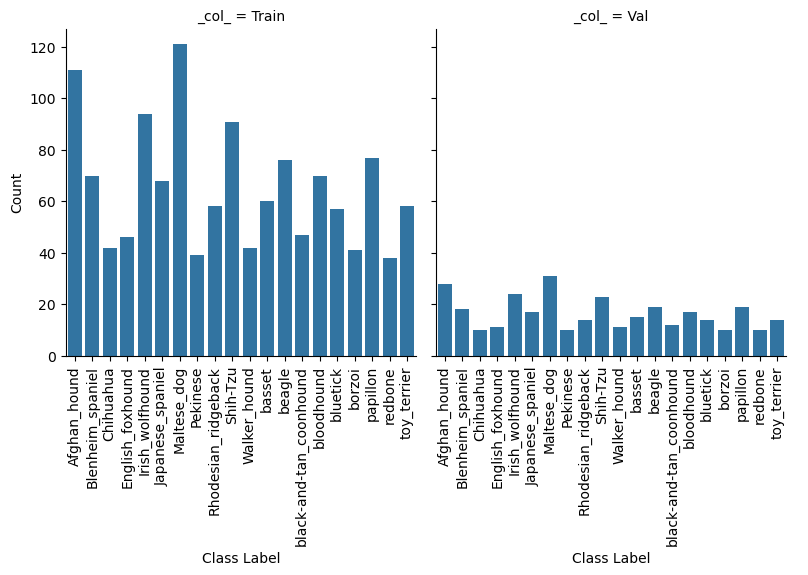

In [7]:
num_classes = len(trainval_dataset.classes)
labels = [data[1] for data in train_dataset] + [data[1] for data in val_dataset]
splits = (["Train"] * len(train_dataset)) + (["Val"] * len(val_dataset))

plt.figure(figsize=(10,5))
g = sns.catplot(x=labels, kind="count", col=splits, height=4, aspect=1, sharey=True)
g.set_axis_labels("Class Label", "Count")
for ax in g.axes.flatten():
    ax.set_xticks(range(num_classes))
    ax.set_xticklabels(trainval_dataset.classes, rotation=90)
plt.show()

# 2) Model 
We are going to use the 'dino + linear classifier' from last week. As we have learned, 
1. Setup model
2. Setup dataloaders
3. Execute Training loop  

In [ ]:

dino = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14')
dino.eval()

class LinearClassifier(nn.Module):
    def __init__(self):
        super().__init__()        
        self.fc = nn.Linear(384, 20)               
    
    def forward(self, x):
        y = self.fc(x)       
        return y
    

We are going to use the balanced dataloader for training and a normal dataloader for validation on top of our data split.

In [9]:
batch_size = 16
train_labels = np.array([data[1] for data in train_dataset])
lbls, counts = np.unique(train_labels, return_counts = True)
weighting = torch.DoubleTensor([1/x for x in counts])
sample_weights = weighting[train_labels]
sampler = torch.utils.data.WeightedRandomSampler(sample_weights, len(train_dataset))

balanced_trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler = sampler)
valloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers = 1)

Just Run the training to get the best model possibel

Using device: cpu


Epoch 1 - training phase: 100%|██████████| 82/82 [01:22<00:00,  1.01s/it]

Training 0: loss=0.967 acc=0.717



Epoch 1 - validation phase: 100%|██████████| 21/21 [00:14<00:00,  1.45it/s]


Validation 0: loss=0.422 acc=0.865


Epoch 2 - training phase: 100%|██████████| 82/82 [01:23<00:00,  1.02s/it]

Training 1: loss=0.254 acc=0.921



Epoch 2 - validation phase: 100%|██████████| 21/21 [00:12<00:00,  1.62it/s]


Validation 1: loss=0.417 acc=0.872


Epoch 3 - training phase: 100%|██████████| 82/82 [01:25<00:00,  1.04s/it]

Training 2: loss=0.175 acc=0.951



Epoch 3 - validation phase: 100%|██████████| 21/21 [00:13<00:00,  1.61it/s]


Validation 2: loss=0.320 acc=0.890


Epoch 4 - training phase: 100%|██████████| 82/82 [01:24<00:00,  1.03s/it]

Training 3: loss=0.125 acc=0.978



Epoch 4 - validation phase: 100%|██████████| 21/21 [00:13<00:00,  1.60it/s]


Validation 3: loss=0.323 acc=0.899


Epoch 5 - training phase: 100%|██████████| 82/82 [01:24<00:00,  1.03s/it]

Training 4: loss=0.094 acc=0.988



Epoch 5 - validation phase: 100%|██████████| 21/21 [00:13<00:00,  1.59it/s]


Validation 4: loss=0.310 acc=0.881


Epoch 6 - training phase: 100%|██████████| 82/82 [01:26<00:00,  1.06s/it]

Training 5: loss=0.088 acc=0.988



Epoch 6 - validation phase: 100%|██████████| 21/21 [00:13<00:00,  1.60it/s]


Validation 5: loss=0.321 acc=0.887


Epoch 7 - training phase: 100%|██████████| 82/82 [01:25<00:00,  1.04s/it]

Training 6: loss=0.069 acc=0.989



Epoch 7 - validation phase: 100%|██████████| 21/21 [00:13<00:00,  1.54it/s]


Validation 6: loss=0.315 acc=0.884


Epoch 8 - training phase: 100%|██████████| 82/82 [01:25<00:00,  1.04s/it]

Training 7: loss=0.058 acc=0.994



Epoch 8 - validation phase: 100%|██████████| 21/21 [00:13<00:00,  1.57it/s]


Validation 7: loss=0.312 acc=0.896


Epoch 9 - training phase: 100%|██████████| 82/82 [01:25<00:00,  1.05s/it]

Training 8: loss=0.054 acc=0.995



Epoch 9 - validation phase: 100%|██████████| 21/21 [00:13<00:00,  1.56it/s]


Validation 8: loss=0.303 acc=0.908


Epoch 10 - training phase: 100%|██████████| 82/82 [01:23<00:00,  1.02s/it]

Training 9: loss=0.054 acc=0.992



Epoch 10 - validation phase: 100%|██████████| 21/21 [00:13<00:00,  1.56it/s]

Validation 9: loss=0.302 acc=0.902


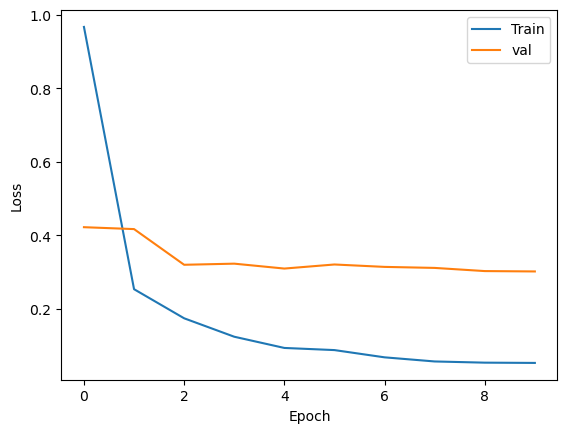

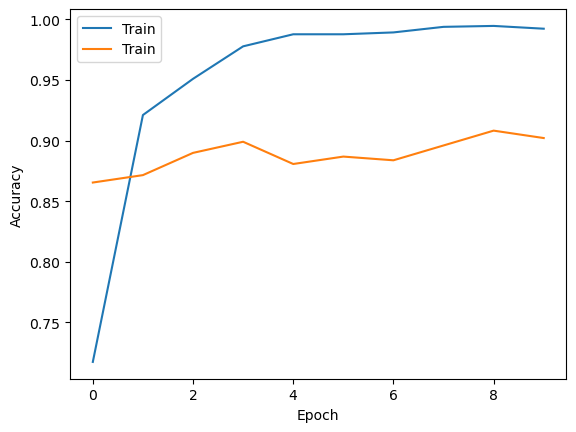

In [ ]:
torch.manual_seed(0)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') #this line checks if we have a GPU available
print(f"Using device: {device}")

#any hyperparameters
lr = 0.001
total_epochs = 10 # five epochs is enough to show improvements

#Step 1: Initialise the model.
linear_classifier = LinearClassifier()
linear_classifier = linear_classifier.to(device)

# Step 2: Define a loss function
criterion = nn.CrossEntropyLoss()
# Step 3: Initialise the SGD optimizer.
optimizer = optim.SGD(linear_classifier.parameters(), lr=lr, momentum=0.9)

#Step 4: For n epochs (e.g. loss converged/stops changing)
total_train_loss, total_val_loss = [], []
total_train_acc, total_val_acc = [], []
best_acc = 0
for epoch in range(total_epochs):    
    #Step 4A: Put the model in "train" mode
    linear_classifier.train() 

    #Step 4B: Training loop: For all batches in the training dataset
    train_loss = []
    correct = 0
    total = 0
    for i, data in  tqdm.tqdm(enumerate(balanced_trainloader, 0), total = len(balanced_trainloader), desc = f'Epoch {epoch+1} - training phase'):
        inputs, labels = data

        # inputs = train_transform(inputs)
        
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        features = dino(inputs)
        outputs = linear_classifier(features)
        
        loss = criterion(outputs, labels)
        
        loss.backward()
        
        optimizer.step()

        train_loss += [loss.cpu().item()]
        
        predicted = torch.argmax(outputs, axis = 1)
        
        correct += torch.sum(predicted == labels).cpu().item()
        total += len(labels)

    mean_train_loss = np.mean(train_loss)
    train_accuracy = correct/total
    print(f"Training {epoch+1}: loss={mean_train_loss:.3f} acc={train_accuracy:.3f}")

    total_train_loss += [mean_train_loss]
    total_train_acc += [train_accuracy]
    
    #Step 4C: Put the model in "eval" mode
    linear_classifier.eval()    

    #Step 4D: Validation loop: For all batches in the validation dataset
    with torch.no_grad(): # not build the computation graph for backpropagation, and thus, no gradients will be computed or stored for the tensors involved in those operations.
        val_loss, val_correct, val_total = 0.0, 0.0, 0.0
        for i, data in  tqdm.tqdm(enumerate(valloader, 0), total = len(valloader), desc = f'Epoch {epoch+1} - validation phase'):
            inputs, labels = data
            
            inputs = inputs.to(device)
            labels = labels.to(device)
    
            features = dino(inputs)
            outputs = linear_classifier(features)
            predicted = torch.argmax(outputs, axis = 1)
            
            loss = criterion(outputs, labels)
            val_loss += loss.cpu().item() * inputs.size(0)
    
            val_correct += torch.sum(predicted == labels).cpu().item()
            val_total += inputs.size(0)
    
        mean_val_loss = val_loss / val_total
        val_accuracy = val_correct / val_total
        print(f"Validation {epoch+1}: loss={mean_val_loss:.3f} acc={val_accuracy:.3f}")
    
        if val_accuracy > best_acc:
            torch.save(linear_classifier.state_dict(), "dino_linear_classifier_best.pth")
            best_acc = val_accuracy

        total_val_loss.append(mean_val_loss)
        total_val_acc.append(val_accuracy)


plt.plot(total_train_loss, label = 'Train')
plt.plot(total_val_loss, label = 'val')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

plt.plot(total_train_acc, label = 'Train')
plt.plot(total_val_acc, label = 'Train')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

Should we still be using Accuracy as validation metric? 
WARNING: A classifier can achieve high accuracy by only predicting the majority class when imbalance exists. 
Let's have a look in other metrics. First using a simpler binary classification problem, later we come back to the multiclass case.

# 3) Hounds Vs Others (Binary Classification)

We will try to classify hound species versus other species. **A hound species is any dog species with the word 'hound' in its name.** 
Below, we will evaluate the performance of our model in this task.
Let's start by running the model in our test set and collecting the ground-truths, predictions, and probabilities.

 Set up the test data loader.

In [12]:
test_dataset = torchvision.datasets.ImageFolder('../Week 5/stanford_dogs_subset/val', transform=transform)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers = 1)
print(f"Test dataset has {len(test_dataset)} samples")

Test dataset has 2000 samples


Load the weights of the best model

In [13]:
linear_classifier = LinearClassifier()
linear_classifier.load_state_dict(torch.load('dino_linear_classifier_best.pth', map_location = 'cpu'))
linear_classifier

LinearClassifier(
  (fc): Linear(in_features=384, out_features=20, bias=True)
)

runing our classifier through the test set to collect ground-truth labels, predicted classes, and estimated porbabilities.

**TASK:** Write a loop to run the model on all samples of the test set. Also, collect the labels and predicted probability vectors for all of them in numpy array.

In [14]:
gts, probs = [], []
with torch.no_grad():
    linear_classifier.eval()
    for i, data in tqdm.tqdm(enumerate(testloader), total=len(testloader), desc="Evaluating"):
        # data
        inputs, label = data
        
        # run model to get prediction
        features = dino(inputs)
        outputs = linear_classifier(features)        
        probability = F.softmax(outputs, dim=-1)    
        
        # collect
        gts.append(label.numpy())
        probs.append(probability.numpy())
        
gts, probs = np.concatenate(gts).astype(np.int32), np.vstack(probs).astype(np.float32)
print(f"{len(gts)}/{probs.shape} labels and predictions collected")
print(gts[0], probs[0])

Evaluating: 100%|██████████| 125/125 [00:46<00:00,  2.67it/s]

2000/(2000, 20) labels and predictions collected
0 [9.9739695e-01 5.1998580e-07 1.7386483e-06 4.9761284e-06 6.3914567e-04
 2.7518046e-05 9.7061366e-06 4.5203118e-04 1.8080065e-04 1.8933575e-05
 1.3558317e-05 4.3336990e-05 1.0479517e-06 1.4165346e-05 6.9489681e-05
 9.1071297e-06 1.0548730e-03 5.5488879e-05 4.2923507e-06 2.2030154e-06]


Finnally, let's transform the multi-class predictions into binary prediction (Hounds vs Other).

**TASK:** Combine the 20 class multi-class predictions into a binary prediction. 

In [24]:
hound_labels = [idx for idx, name in enumerate(test_dataset.classes) if  'hound' in name]
gts_hounds = np.isin(gts,hound_labels)
probs_hounds = probs[:, hound_labels].sum(axis=1)

#### Evaluation

We can use [ConfusionMatrixDisplay](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html) from sklearn.metrics to create a confusion matrix.

Below, we use the ConfusionMatrixDisplay.from_predictions() function to create the confusion matrix.

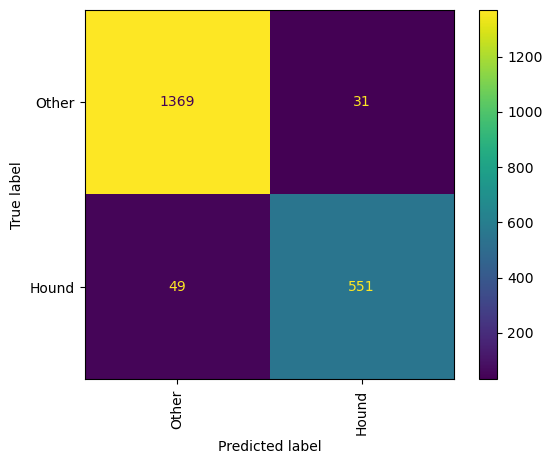

In [27]:
preds_hounds  = probs_hounds > 0.5
ConfusionMatrixDisplay.from_predictions(gts_hounds, preds_hounds, display_labels=['Other', 'Hound'], xticks_rotation='vertical')

Can we do it by ourselves? 

In a **binary classification** problem, the **confusion matrix** is defined by the following counts:

|                  | Predicted Negative | Predicted Positive |
|------------------|-------------------|-------------------|
| **Actual Negative** | True Negative (TN) | False Positive (FP) |
| **Actual Positive** | False Negative (FN) | True Positive (TP) |


- TP (True Positive): Model predicts positive, and the true label is positive.
- FP (False Positive): Model predicts positive, but the true label is negative.
- TN (True Negative): Model predicts negative, and the true label is negative.
- FN (False Negative): Model predicts negative, but the true label is positive.

OBS: Sometimes this matrix can look transposed.

**TASK:** Compute these counts using only numpy and plot a confusion matrix like sklearn one using matplotlib: 


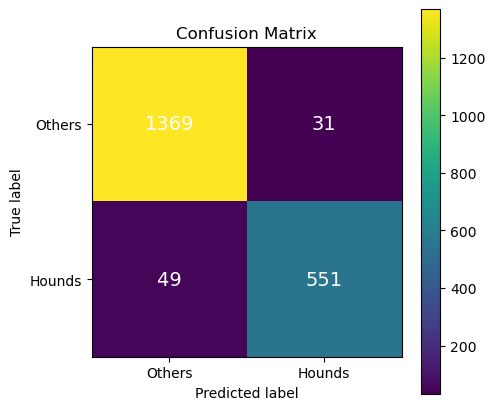

In [31]:
# obs make sure gts_hounds and preds_hounds are boolean vectors 
preds_hounds  = probs_hounds > 0.5
tp = np.logical_and(preds_hounds, gts_hounds).sum() 
fp = np.logical_and(preds_hounds, ~gts_hounds).sum() 
tn = np.logical_and(~preds_hounds, ~gts_hounds).sum() 
fn =  np.logical_and(~preds_hounds, gts_hounds).sum()

cm_counts = np.array([[tn, fp], [fn, tp]]).astype(np.int32)

labels = ['Others', 'Hounds']

fig, ax = plt.subplots(figsize=(5,5))
im = ax.imshow(cm_counts, cmap='viridis')

# Add text annotations
for i in range(cm_counts.shape[0]):
    for j in range(cm_counts.shape[1]):
        ax.text(j, i, str(cm_counts[i, j]),
                ha='center', va='center', color='white', fontsize=14)

# Set ticks and labels
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')
ax.set_title('Confusion Matrix')

# Optional: colorbar
plt.colorbar(im, ax=ax)
plt.show()


From the confusion matrix, we can compute classification metrics and curves that will help us to evaluate our model:

###  Precision
Precision measures the proportion of correctly predicted positive samples out of all samples predicted as positive.

$$
\text{Precision} = \frac{TP}{TP + FP} = \frac{TP}{PP}
$$

- High precision → very few false positives.  
- Example: Out of all dogs predicted to be hound dogs, how many really are?


### Recall (Sensitivity, True Positive Rate)
Recall measures the proportion of correctly predicted positive samples out of all actual positive samples.

$$
\text{Recall} = \frac{TP}{TP + FN} = \frac{TP}{P}
$$

- High recall → very few false negatives.  
- Example: Out of all dogs that are actually hound dogs, how many did we detect?


###  F-Score (F1-Score)
The F-score is the harmonic mean of precision and recall. It balances the two metrics:

$$
\text{F1} = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}
$$

- High F1 means both precision and recall are reasonably high.  
- Useful when there is **class imbalance**.

Let's compute these metrics for hounds vs others problem.

**TASK:** From the confusion matrix counts computed above, compute precision, recall and f-score. 

In [34]:
prec = tp/(tp+fp)
rec = tp/(tp+fn)
fscore = (2 * (prec * rec)) / (prec + rec)
print(f"precision={prec:.2f}, recall={rec:.2f}, f-score={fscore:.2f}")

precision=0.95, recall=0.92, f-score=0.93


However, this performance is calculated for a threshold of 0.5. You can re-run the code using different thresholds. By setting different thresholds, we obtain different results. Which threshold should we choose, and how can we compare or evaluate performance across all possible thresholds?

To answer this question, let's have a look in the distribution of our predictions.

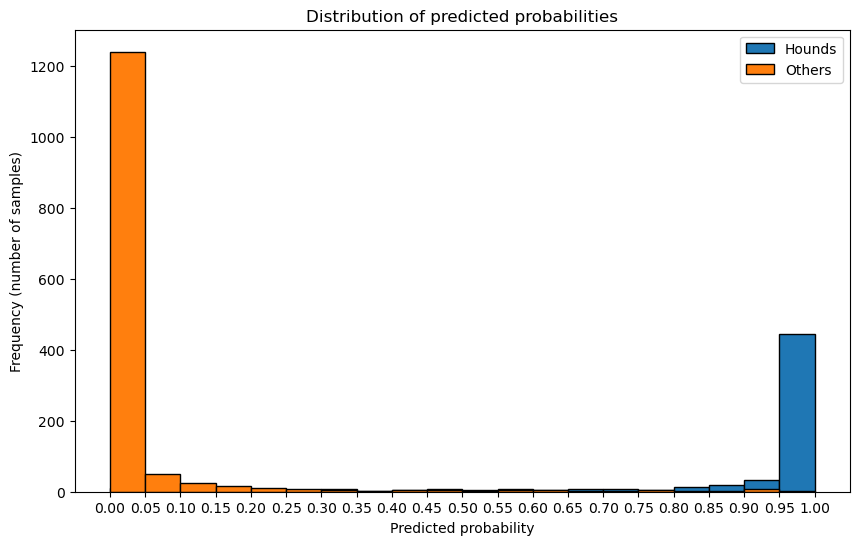

In [ ]:
# Create histogram
num_bins = 10  # number of bins (e.g., 0.0–0.1, 0.1–0.2, ..., 0.9–1.0)
hounds_counts, hounds_bin_edges = np.histogram(probs_hounds[gts_hounds], bins=num_bins, range=(0, 1))
others_counts, others_bin_edges = np.histogram(probs_hounds[~gts_hounds], bins=num_bins, range=(0, 1))

# Plot histogram using matplotlib
plt.figure(figsize=(10, 6))
plt.bar(hounds_bin_edges[:-1], hounds_counts, width=hounds_bin_edges[1] - hounds_bin_edges[0], edgecolor='black', align='edge', label='Hounds', alpha=0.5)
plt.bar(others_bin_edges[:-1], others_counts, width=others_bin_edges[1] - others_bin_edges[0], edgecolor='black', align='edge', label='Others', alpha=0.5)
plt.xlabel('Predicted probability')
plt.ylabel('Frequency (number of samples)')
plt.title('Distribution of predicted probabilities')
plt.xticks(np.linspace(0, 1, num_bins + 1))  # ticks at each bin edge
plt.legend()
plt.show()

### ROC Curve

The **ROC (Receiver Operating Characteristic) curve** is a tool to evaluate the performance of a **binary classifier** across **all possible thresholds**.  

- **x-axis:** False Positive Rate (FPR)  (also called 1−Specificity)
$$
\text{FPR} = \frac{FP}{FP + TN} = \frac{FP}{N}
$$  

- **y-axis:** True Positive Rate (TPR) (also named sensitivity)  
$$
\text{TPR} = \text{Recall} = \frac{TP}{TP + FN} = \frac{TP}{P}
$$  

- Each point on the curve corresponds to a different **decision threshold** used to convert probabilities into class labels.  

- The **diagonal line** represents random guessing; points above it indicate better-than-random performance.

- The classifier's performance on the ROC curve is often summarized by a single number: the area under the ROC curve (**AUC-ROC**).

- Sklearn provide functions to compute [ROC](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html) curve and [AUC-ROC](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html). But, we can also do by ourselves.

**TASK:** Complete the code below to plot the ROC curve. Specifically, fill out the loop computing tpr and fpr.


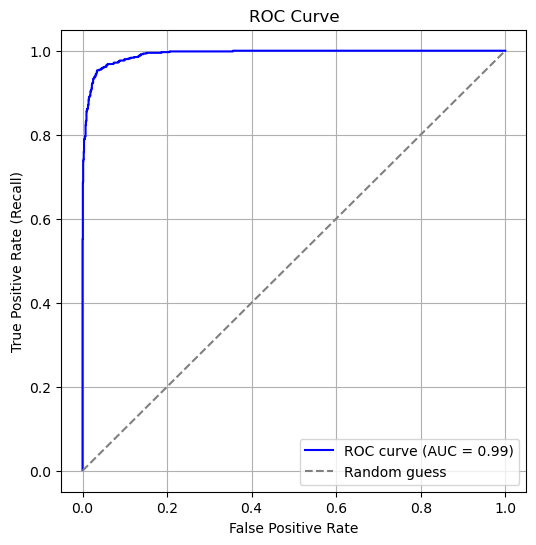

In [31]:
# Sort scores and corresponding true labels descending
desc_order = np.argsort(-probs_hounds)
y_true_sorted = gts_hounds[desc_order]
y_scores_sorted = probs_hounds[desc_order]

# Initialize counts
TP, FP = 0, 0,  
P, N = np.sum(gts_hounds == 1), np.sum(gts_hounds == 0)


tpr_list = []
fpr_list = []

for label in y_true_sorted:
    if label == 1:
        TP += 1
    else:
        FP += 1
    tpr_list.append(TP / P)
    fpr_list.append(FP / N)

# Convert to numpy arrays
tpr = np.array(tpr_list)
fpr = np.array(fpr_list)
auc = np.trapezoid(tpr, fpr)

# Plot ROC curve
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()

# 3) Classifier Calibration

Calibration measures how well a classifier's **predicted probabilities** match the **true likelihood of an event**.  

- A perfectly calibrated model outputs probabilities that reflect the actual frequency of positives.  
- Example (binary classification):
  - If the model predicts **0.7** for 100 samples, roughly **70 of them should belong to the positive class**.
  - If it predicts **0.2**, about **20 should be positive**.

WARN: High accuracy does not guarantee well-calibrated probabilities, which can make them unreliable for decision-making, risk assessment, or thresholding.


Let's plot a calibration curve to check our classifier

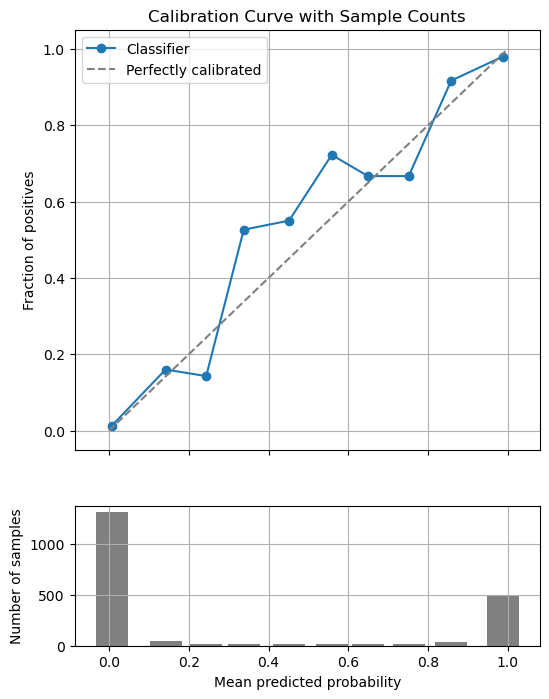

In [42]:
# Number of bins
n_bins = 10
bins = np.linspace(0, 1, n_bins + 1)

bin_indices = np.digitize(probs_hounds, bins) - 1  # get bin index for each probability
bin_true_frac = []
bin_mean_prob = []
bin_counts = []

for i in range(n_bins):
    mask = bin_indices == i
    mask_sum = np.sum(mask)
    bin_counts.append(mask_sum)
    if mask_sum > 0:
        bin_true_frac.append(np.mean(gts_hounds[mask]))  # fraction of positives
        bin_mean_prob.append(np.mean(probs_hounds[mask]))  # mean predicted probability
    else:
        bin_true_frac.append(np.nan)
        bin_mean_prob.append(np.nan)

# Convert to arrays
bin_true_frac = np.array(bin_true_frac)
bin_mean_prob = np.array(bin_mean_prob)
bin_counts = np.array(bin_counts)

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6,8), sharex=True, gridspec_kw={'height_ratios':[3,1]})

# Top: calibration curve
ax1.plot(bin_mean_prob, bin_true_frac, marker='o', label='Classifier')
ax1.plot([0,1], [0,1], linestyle='--', color='gray', label='Perfectly calibrated')
ax1.set_ylabel('Fraction of positives')
ax1.set_title('Calibration Curve with Sample Counts')
ax1.grid(True)
ax1.legend()

# Bottom: histogram of counts
ax2.bar(bin_mean_prob, bin_counts, width=0.08, color='gray')
ax2.set_xlabel('Mean predicted probability')
ax2.set_ylabel('Number of samples')
ax2.grid(True)

plt.show()

### Overconfident and Underconfident Predictions

- **Overconfident:** Predicted probabilities are **too high** compared to actual outcomes.  
  - Example: The model predicts 0.9, but only 60% of samples are truly positive.  
  - Calibration Curve **below** the diagonal
- **Underconfident:** Predicted probabilities are **too low** compared to actual outcomes.  
  - Example: The model predicts 0.4, but 70% of samples are truly positive.  
  - Calbration Curve **above** the diagonal


# Extending Binary Metrics to Multi-class Classification

So far, we have discussed metrics, ROC curves, and calibration in the context of **binary classification**.  

**Question:**  
How could you adapt these concepts to a **multi-class classification problem**? Consider:

- How would you compute precision, recall, and F1-score when there are more than two classes?  
- How can ROC curves and AUC be extended beyond binary problems?  
- How could you assess and visualize calibration for multiple classes?

Try to think about strategies like **one-vs-rest**, **macro vs. micro averaging**, and grouping classes.  

**Reading:**  
- [scikit-learn: Multiclass classification Metrics](https://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics)  
- [scikit-learn: ROC curves for multiclass](https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html)  
- [scikit-learn: Calibration of classifiers](https://scikit-learn.org/stable/modules/calibration.html)


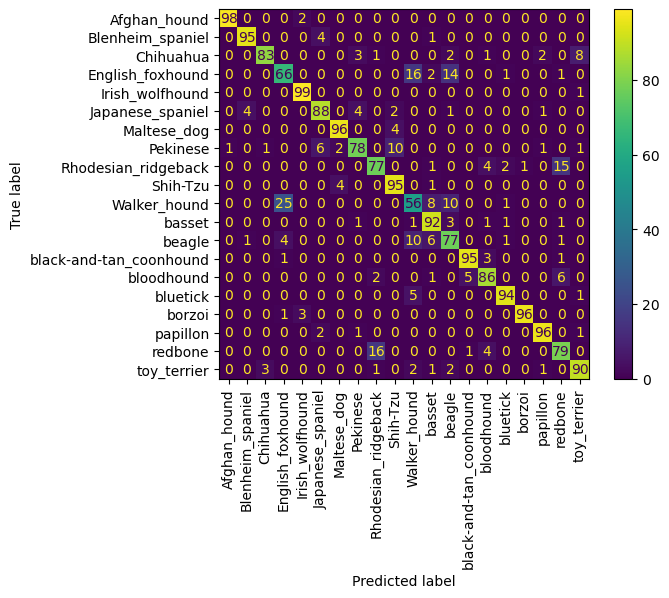

In [36]:
ConfusionMatrixDisplay.from_predictions(gts, np.argmax(probs,axis=1), display_labels=test_dataset.classes, xticks_rotation='vertical')